In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
# import plotly.express as pltly
# import plotly
import pandas as pd
from functools import partial
import networkx as net
# import plotly.graph_objects as go

In [2]:
np.set_printoptions(suppress = True)

parameters for $\mu-L$ convergence
* $\mu = 2\lambda$       regularization parameter

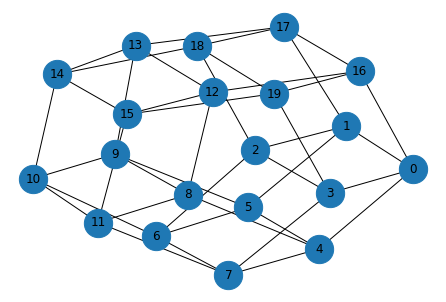

In [3]:
K = 20
# train_images=train_images.reshape((60000,784),order='C')
# SampleCov=[(train_images[sample_indices[i]].T @ train_images[sample_indices[i]]) / len(sample_indices[i]) for i in range(K)]
# lambdaSampleCov=[np.linalg.eigvalsh(SampleCov[i]).reshape((784,1)) for i in range(K)]
# E = 1./2*(np.eye(K) - np.ones((K,1)) @ np.ones((1,K)) / K)
# lambdaE=np.linalg.eigvalsh(E).reshape((K,1))
# lambda_base = [max(.5*lambdaSampleCov[i]).squeeze() for i in range(K)]
lamda = .002
# L = max(lambda_base) + lamda
L = .1581 + .002
mu = lamda
kappa = L / mu
gb = .1 # as the norm bound G for gradient
bar_sigma_sqr= 1.
a0 = 20 # initial distance between the average model parameter and the optimal one


seeds = iter(range(1000))
prob = 0.2
alg_connect = 0
while alg_connect < 1e-4:
#     # Generate a star-based ER graph
#     ER = net.erdos_renyi_graph(K-1, 0.2, seed = next(seeds))
#     ER.add_node(K-1)
#     G = net.star_graph(reversed(range(K)))
#     G.add_edges_from(ER.edges())

#     # Generate an arbitrary ER graph
#     G = net.erdos_renyi_graph(K, p, seed = next(seeds))

#     # Generate a ring(cycle) graph
#     G = net.cycle_graph(K)
#     G.remove_edge(0, K-1)

    # Generate a 2-D torus (5-by-4)
    G = net.grid_2d_graph(5, 4, periodic=True)
    mapping = {(m,n):4*m+n for m, n in G.nodes()}
    _ = net.relabel_nodes(G, mapping, copy=False)

#     # Generate a complete graph
#     G = net.complete_graph(K)

    LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
    E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
    alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
pos = net.spring_layout(G)
net.draw(G, pos, with_labels = True, node_size = 800, edge_size = 1000, font_size = 12)

delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)


# The optimum a' adpative to other paramters to minimize the upper-bound for optimality gap
# a_prime = ( (169 * 2 * gb**2 * delta) / (mu**2 * c**2 * rho**2 * (2-omega) * m**2/d * zeta_ini) ) ** (1/3)
# when p(t) >= p_ini for the whole training iterations
# a_prime = ( (169 * 2 * gb**2 * 4 * p_ini) / (mu**2 * c**2 * rho**2 * (2-omega) * m**2/d * zeta_ini**2) ) ** (1/3)

In [4]:
delta

0.3071035580555791

In [5]:
beta

1.692896441944421

*The parameters in the following block is applicable to the upper-bound for the digital scheme only.*

In [4]:
np.random.seed(2)

num_lack_max = 4
num_lack = np.random.random_integers(0,num_lack_max,(K,))
for k in range(K):
    arr = np.ones((10,))
    arr[:num_lack[k]] = 0
    np.random.shuffle(arr)
        
d_min = 50
d_max = 200
rho =  d_min + (d_max - d_min) * np.random.rand(K,1) 
theta = 2 * np.pi * np.random.rand(K,1)
# D = np.ones((K, K))
D = np.sqrt(rho ** 2 + rho.T ** 2 - 2 * (rho @ rho.T) * np.cos(theta - theta.T))
# Fill in D[i,i] some non-zero value to avoid Inf in PL
for i in range(K):
    if i:
        D[i,i] = D[i,i-1]
    else:
        D[i,i] = D[i,i+1]
A0 = 10 ** (-3.35)
d0 = 1
gamma = 3.76
# PL = A0 * ((D / d0) ** (-gamma))

d = 7850
# N = 7943
# barP = 2e-6
# M = 10 # the chromatic number for the digital scheme
N0 = 10 ** (-169/10) * 1e-3
c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
b = 64

funcG= lambda barP, M, N, n, i:np.exp(-( 2 ** (n*b*M / N) - 1 ) / (barP / N0) * c_array[i] / (M * A0) )
# omega = min( 1- funcG(barP, M, N, 1, i) + sum(funcG(barP, M, N, n, i) for n in range(1,d+1)) / d for i in range(K) )
p = lambda delta, beta, omega: delta**2 * omega / (2 * (16*delta + delta**2 + 4*beta**2 + 2*delta*beta**2 - 8*delta*omega))
zeta0 = lambda delta, beta, omega: delta * omega / (16*delta + delta**2 + 4*beta**2 + 2*delta*beta**2 - 8*delta*omega)

C:\Users\Helen\.conda\envs\dsgd\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 4 + 1) instead
  after removing the cwd from sys.path.


In [22]:
13 * L / mu

1040.6499999999999

In [23]:
delta

0.3071035580555791

In [24]:
beta

1.692896441944421

In [25]:
zeta0(delta,beta,omega)

0.00018950017601273233

In [28]:
barP = 2e-7
N = 7943
M = 8
p(delta,beta,omega)

2.9098089152834303e-05

In [30]:
max(5/p(delta,beta,omega), 13 * L/mu)

171832.5892033008

Theorem 1 
$$\mathbb{E}[f(x^{(T)}_{avg})-f(x^\ast)]\le\frac{\mu}{3.25}\frac{a^3-3.25a^2}{S_T}v_e^{(0)} + \frac{1.625T(T+2a)}{\mu S_T}\frac{{\bar\sigma}^2}{K}+\frac{158.45\times 24LT}{\mu^2(p(\delta,\omega))^2S_T}G^2$$

Theorem 2 (modification of Theorem 19 [A.Koloskova *et al.* 19])
$$\mathbb{E}[f(x^{(T)}_{avg})-f(x^\ast)]\le\frac{\mu}{3.25}\frac{a^3-3.25a^2}{S_T}v_e^{(0)}+\frac{1.625T(T+2a)}{\mu S_T}\frac{\bar\sigma^2}{K}+\frac{158.45\left(24G^2+\frac{A(\delta,\omega)}{K}\sqrt[\leftroot{-2}\uproot{4}4]{\tilde N_{0,T}}\right)LT}{\mu^2(p^{(T)}(\delta,\omega))^2 S_T}+C(\delta,\omega)$$
in which $p^{(t)}(\delta,\omega)=\min\{\tilde p^{(t)}(\delta,\omega), p(\delta,\omega)\}$ with  
$$\tilde p^{(t)}(\delta,\omega)=\frac{\delta\zeta_0}{\sqrt[\leftroot{-2}\uproot{4}4]{\tilde N_{0,T}}t/a^\prime+1}-\left(\frac{\delta^2}{4}+\frac{2}{\omega}\beta^2\right)\frac{\zeta_0^2}{\big(\sqrt[\leftroot{-2}\uproot{4}4]{\tilde N_{0,T}}t/a^\prime+1\big)^2}, $$ and 
$$C(\delta,\omega)=\frac{1}{K^2}(\zeta_0(\delta,\omega)a^\prime)^2\omega^2d\frac{\mu}{3.25}\sqrt{\tilde N_{0,T}}$$
$$A(\delta,\omega)=\delta(\zeta_0(\delta,\omega)a^\prime)^3(2-\omega)\omega^2d\left(\frac{\mu}{3.25}\right)^2$$

**Evaluate the analytical upper-bound  for $F({\bar{\theta}}^{(t)}) - F^\ast$ with varying $\rho$**

C:\Users\Helen\.conda\envs\dsgd\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


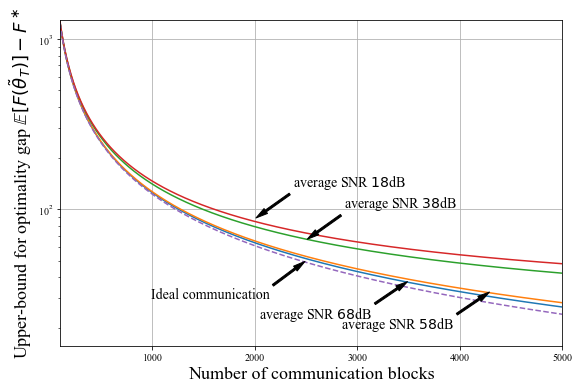

In [8]:
a = 10e6
M = 8 # the chromatic number for the digital scheme
N = 7943
opt = 0.41

# Generate a 2-D torus (5-by-4)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)

Tmax = 5e3
T_array = np.arange(1,Tmax)
sT = np.cumsum((a+T_array)**2)
plt.rc('font', family='Times New Roman')
fig, ax = plt.subplots(figsize = (9.0,6.0))


barP = 2e-3

omega = min( 1- funcG(barP, M, N, 1, i) + sum(funcG(barP, M, N, n, i) for n in range(1,d+1)) / d for i in range(K) )
og1 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og1 - opt)


barP = 2e-4

omega = min( 1- funcG(barP, M, N, 1, i) + sum(funcG(barP, M, N, n, i) for n in range(1,d+1)) / d for i in range(K) )
og2 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og2 - opt)


barP = 2e-6

omega = min( 1- funcG(barP, M, N, 1, i) + sum(funcG(barP, M, N, n, i) for n in range(1,d+1)) / d for i in range(K) )
og3 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og3 - opt)


barP = 2e-8

omega = min( 1- funcG(barP, M, N, 1, i) + sum(funcG(barP, M, N, n, i) for n in range(1,d+1)) / d for i in range(K) )
og4 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og4 - opt)

# ideal communication with the estimation quality omega = 1
omega = 1
og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og - opt, '--')



plt.xlabel(r'Number of communication blocks', fontsize = 18)
plt.ylabel(r'Upper-bound for optimality gap $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
plt.xlim((100, 5000))
plt.ylim((0, 1300))
plt.grid()

# # Place legend for individual curves
# plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'average SNR $18$dB',
            xy = (2000, 88), xycoords = 'data',
            xytext = (38, 32), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'average SNR $38$dB',
            xy = (2500, 66), xycoords = 'data',
            xytext = (38, 32), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'Ideal communication',
            xy = (2500, 50), xycoords = 'data',
            xytext = (-155, -38), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'average SNR $68$dB',
            xy = (3500, 38), xycoords = 'data',
            xytext = (-150, -38), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'average SNR $58$dB',
            xy = (4300, 33), xycoords = 'data',
            xytext = (-150, -38), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_ub_og_vs_SNR.eps',format='eps', dpi=600)
plt.show()

In [1091]:
og4[99]

1254.4825916327848

In [290]:
type(og-opt)

numpy.ndarray

In [355]:
barP = 2e-4

In [356]:
omega = min( 1- funcG(barP, M, N, 1, i) + sum(funcG(barP, M, N, n, i) for n in range(1,d+1)) / d for i in range(K) )

In [418]:
omega = 1

In [369]:
delta

0.3071035580555791

In [370]:
beta

1.692896441944421

In [419]:
5 / p(delta, beta, omega)

1672.628095871042

**Evaluate the emprical optimality gap of $F({\bar{\theta}}^{(t)}) - F^\ast$ with varying $\rho$**

In [5]:
# K = losseses.shape[2]
opt = 0.41
losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_1_eta0_2.00_zeta0_1.00_10-0_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df1 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_2_P_2.0000mW_N_7943_a_200.00_zeta0_0.0005_a_prime_100.00_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df2 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_2_P_0.2000mW_N_7943_a_200.00_zeta0_0.0005_a_prime_100.00_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df3 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_2_P_0.0020mW_N_7943_a_200.00_zeta0_0.0005_a_prime_100.00_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df4 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_2_P_0.00002mW_N_7943_a_200.00_zeta0_0.0005_a_prime_100.00_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df5 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('./data/simulations/losseses_SCHEME_2_P_0.0020mW_N_7943_a_200.00_zeta0_0.0020_a_prime_100.00_ER.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df6 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('./data/losseses_SCHEME_1_eta0_2.00_zeta0_1.00_10-0.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df7 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_local_eta0_2.00.pkl', 'rb') )
losseses = np.array(losseses) - opt
df8 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

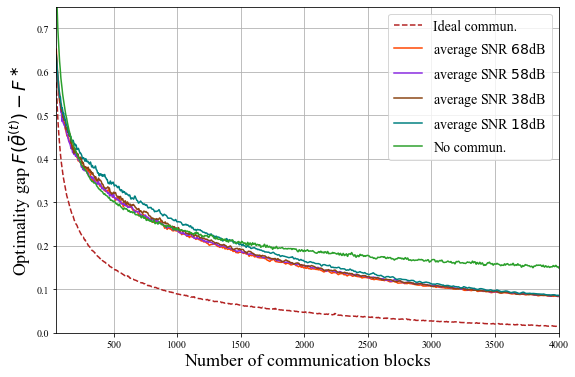

In [6]:
plt.rc('font', family='Times New Roman')
fig, ax = plt.subplots(figsize = (9.0,6.0))
df1.rolling(window = 10).mean().mean(axis = 1).plot(style = '--', color = 'firebrick', label = r'Ideal commun.')
df2.rolling(window = 30).mean().mean(axis = 1).plot(color = 'orangered', label = r'average SNR $68$dB')
df3.rolling(window = 30).mean().mean(axis = 1).plot(color = 'blueviolet', label = r'average SNR $58$dB')
df4.rolling(window = 30).mean().mean(axis = 1).plot(color = 'saddlebrown', label = r'average SNR $38$dB')
df5.rolling(window = 30).mean().mean(axis = 1).plot(color = 'teal', label = r'average SNR $18$dB')
# df6.rolling(window = 20).mean().mean(axis = 1).plot(color = 'tab:blue', label = r'ER graph ($\delta=0.14$)')
# df7.rolling(window = 10).mean().mean(axis = 1).plot(style = '--', color = 'blueviolet', label = 'Ideal commun.')
df8.rolling(window = 30).mean().mean(axis = 1).plot(color = 'tab:green', label = 'No commun.')

plt.xlabel(r'Number of communication blocks', fontsize = 18)
plt.ylabel(r'Optimality gap $F(\bar{\theta}^{(t)})-F^\ast$', fontsize = 18)
# plt.title(r'ER graph with $p = 0.2$ and $\barP = -57$dBm', fontsize = 14)
plt.xlim((50, 4000))
plt.ylim((0, 0.75))
plt.grid()

# Place legend for individual curves
plt.legend(loc = 'upper right', fontsize = 14)
# # Place marks using annotation
# _ = ax.annotate(r'Ideal communications',
#             xy = (1400, .08), xycoords = 'data',
#             xytext = (-30, -32), textcoords = 'offset points', fontsize = 16,
#             arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
# _ = ax.annotate(r'Digital transmission',
#             xy = (2200, .06), xycoords = 'data',
#             xytext = (36, 28), textcoords = 'offset points', fontsize = 16,
#             arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# _ = plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_og_vs_SNR.eps',format='eps', dpi=600)
plt.show()

**Evaluate the analytical upper-bound for $F({\bar{\theta}}^{(t)}) - F^\ast$ under varying topologies**

C:\Users\Helen\.conda\envs\dsgd\lib\site-packages\ipykernel_launcher.py:94: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


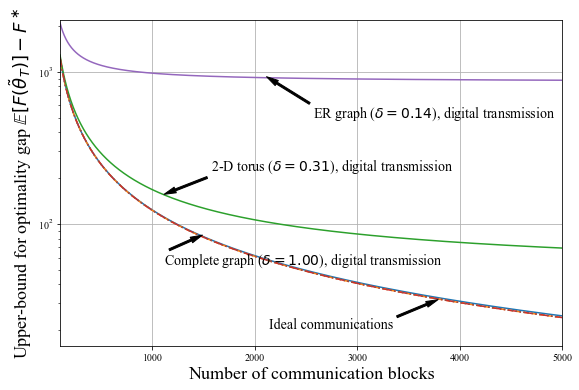

In [1269]:
a = 1e7
M = 20 # the chromatic number for the digital scheme
N = 10000
opt = 0.41
barP = 2e-6

Tmax = 5e3
T_array = np.arange(1,Tmax)
sT = np.cumsum((a+T_array)**2)
plt.rc('font', family='Times New Roman')
fig, ax = plt.subplots(figsize = (9.0,6.0))


# Generate a complete graph
G = net.complete_graph(K)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP

omega = min( 1- funcG(barP, M, N, 1, i) + sum(funcG(barP, M, N, n, i) for n in range(1,d+1)) / d for i in range(K) )
delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)
og1 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og1 - opt, label=r'Complete graph (digital)')
# ideal communication with the estimation quality omega = 1
omega = 1
og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og - opt, '--', label=r'Complete graph (ideal)')


# Generate a 2-D torus (5-by-4)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP

omega = min( 1- funcG(barP, M, N, 1, i) + sum(funcG(barP, M, N, n, i) for n in range(1,d+1)) / d for i in range(K) )
delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)
og2 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og2 - opt, label=r'2-D torus (digital)')
# ideal communication with the estimation quality omega = 1
omega = 1
og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og - opt, '-.', label=r'2-D torus (ideal)')


# Generate an arbitrary ER graph
seeds = iter(range(1000))
prob = 0.2
alg_connect = 0
while alg_connect < 1e-4:
    G = net.erdos_renyi_graph(K, prob, seed = next(seeds))
    LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
    E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
    alg_connect = E[1]
    alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP

omega = min( 1- funcG(barP, M, N, 1, i) + sum(funcG(barP, M, N, n, i) for n in range(1,d+1)) / d for i in range(K) )
delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)
og3 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og3 - opt, label=r'ER graph (digital)')
# ideal communication with the estimation quality omega = 1
omega = 1
og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og - opt, ':', label=r'ER Graph (ideal)')



plt.xlabel(r'Number of communication blocks', fontsize = 18)
plt.ylabel(r'Upper-bound for optimality gap $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
plt.xlim((100, 5000))
plt.ylim((0, 2200))
plt.grid()

# # Place legend for individual curves
# plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'ER graph ($\delta=0.14$), digital transmission',
            xy = (2100, 940), xycoords = 'data',
            xytext = (48, -42), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'2-D torus ($\delta=0.31$), digital transmission',
            xy = (1100, 155), xycoords = 'data',
            xytext = (48, 24), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'Complete graph ($\delta=1.00$), digital transmission',
            xy = (1500, 85), xycoords = 'data',
            xytext = (-40, -30), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'Ideal communications',
            xy = (3800, 32), xycoords = 'data',
            xytext = (-170, -30), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_ub_og_vs_topology.eps',format='eps', dpi=600)
plt.show()

In [1249]:
og1.min()

25.244723890884046

In [1227]:
og2.min()

77.84145331010612

In [1270]:
og3.min()

879.6695397484401

In [1271]:
og3[99]

2086.236906845158

In [1157]:
delta

0.14251644134953867

In [983]:
beta

1.692896441944421

**Evaluate the emprical optimality gap of $F({\bar{\theta}}^{(t)}) - F^\ast$ under different topologies**

In [1275]:
# K = losseses.shape[2]
opt = 0.41
losseses = pickle.load( open('./data/simulations/losseses_SCHEME_1_eta0_2.00_zeta0_1.00_10-0_CG.pkl', 'rb') )
losseses = np.array(losseses) - opt
df1 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('./data/simulations/losseses_SCHEME_1_eta0_2.00_zeta0_1.00_10-0_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df2 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('./data/simulations/losseses_SCHEME_1_eta0_2.00_zeta0_1.00_10-0_ER.pkl', 'rb') )
losseses = np.array(losseses) - opt
df3 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('./data/simulations/losseses_SCHEME_2_P_0.0020mW_N_7943_a_200.00_zeta0_0.0020_a_prime_100.00_CG.pkl', 'rb') )
losseses = np.array(losseses) - opt
df4 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('./data/simulations/losseses_SCHEME_2_P_0.0020mW_N_7943_a_200.00_zeta0_0.0020_a_prime_100.00_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df5 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('./data/simulations/losseses_SCHEME_2_P_0.0020mW_N_7943_a_200.00_zeta0_0.0020_a_prime_100.00_ER.pkl', 'rb') )
losseses = np.array(losseses) - opt
df6 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('./data/losseses_SCHEME_1_eta0_2.00_zeta0_1.00_10-0.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df7 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('./data/simulations/losseses_local_eta0_2.00.pkl', 'rb') )
losseses = np.array(losseses) - opt
df8 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


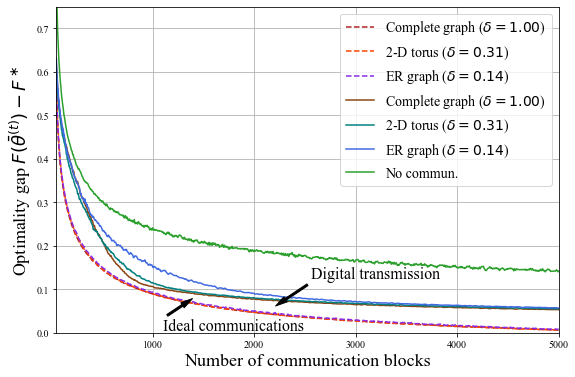

In [1279]:
plt.rc('font', family='Times New Roman')
fig, ax = plt.subplots(figsize = (9.0,6.0))
df1.rolling(window = 10).mean().mean(axis = 1).plot(style = '--', color = 'firebrick', label = r'Complete graph ($\delta=1.00$)')
df2.rolling(window = 10).mean().mean(axis = 1).plot(style = '--', color = 'orangered', label = r'2-D torus ($\delta=0.31$)')
df3.rolling(window = 10).mean().mean(axis = 1).plot(style = '--', color = 'blueviolet', label = r'ER graph ($\delta=0.14$)')
df4.rolling(window = 30).mean().mean(axis = 1).plot(color = 'saddlebrown', label = r'Complete graph ($\delta=1.00$)')
df5.rolling(window = 30).mean().mean(axis = 1).plot(color = 'teal', label = r'2-D torus ($\delta=0.31$)')
df6.rolling(window = 30).mean().mean(axis = 1).plot(color = 'royalblue', label = r'ER graph ($\delta=0.14$)')
# df7.rolling(window = 10).mean().mean(axis = 1).plot(style = '--', color = 'blueviolet', label = 'Ideal commun.')
df8.rolling(window = 30).mean().mean(axis = 1).plot(color = 'tab:green', label = 'No commun.')

plt.xlabel(r'Number of communication blocks', fontsize = 18)
plt.ylabel(r'Optimality gap $F(\bar{\theta}^{(t)})-F^\ast$', fontsize = 18)
# plt.title(r'ER graph with $p = 0.2$ and $\barP = -57$dBm', fontsize = 14)
plt.xlim((50, 5000))
plt.ylim((0, 0.75))
plt.grid()

# Place legend for individual curves
plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'Ideal communications',
            xy = (1400, .08), xycoords = 'data',
            xytext = (-30, -32), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'Digital transmission',
            xy = (2200, .06), xycoords = 'data',
            xytext = (36, 28), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# _ = plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_og_vs_topology.eps',format='eps', dpi=600)
plt.show()